# Organizing and Sorting Images

In this notebook, we will learn how to use a pretrained neural network to perform feature extraction on a subset of images from the Caltech 101 image dataset. We will then use these features to perform unsupervised clustering and determine key groups of images, use a dimensionality reduction method known as UMAP to reduce the feature vectors down to two dimensions, and finally use Mario Klingemann's Rasterfairy to transform these point clouds to a grid. Parts of the code for this notebook are taken from the ml4a [image search](https://github.com/ml4a/ml4a-guides/blob/master/notebooks/image-search.ipynb) and [image tsne](https://github.com/ml4a/ml4a-guides/blob/master/notebooks/image-tsne.ipynb) notebooks.

Before running this notebook, be sure to download the [Caltech101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/#Download) dataset and place the downloaded and unzipped folder of images in the root directory of the notebook in a folder named "caltech101". You can also prepare your own dataset - place in a folder also at the root of this notebook and modify the code in order to load those images.

In [1]:
# First we'll start by loading the relevant libraries we'll need
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Model

We'll be using the pretrained VGG16 network which is fortunately already built into Keras - importing is a easy as invoking one line of code! If this is your first time using VGG16 there will be a ~45 second delay in downloading it.

In [2]:
# Loading our model
model = keras.applications.VGG16(weights='imagenet', include_top=True)

# Then we create another model, plugging the previous model's input into our 
# input, and grabbing the last layer before classification as the output.
# These simply act as "pointers" to the original model
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Next, we use the Python `glob` library to list all the files in our image directory with a ".jpg" file extension. We then shuffle them in order to randomize their order since they are all listed in order of type. Finally, we grab only the first 1000 images.

In [3]:
import glob
import random

images = glob.glob('./caltech101/**/*.jpg')

random.shuffle(images)

images = images[:1000]

Next we bulk calculate all our features and add them to a list

In [4]:
import numpy as np

features = []
for i, image_path in enumerate(images):
    if i % 10 == 0:
        print("analyzed " + str(i) + " out of " + str(len(images)))
    
    img = image.load_img(image_path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

analyzed 0 out of 1000
analyzed 10 out of 1000
analyzed 20 out of 1000
analyzed 30 out of 1000
analyzed 40 out of 1000
analyzed 50 out of 1000
analyzed 60 out of 1000
analyzed 70 out of 1000
analyzed 80 out of 1000
analyzed 90 out of 1000
analyzed 100 out of 1000
analyzed 110 out of 1000
analyzed 120 out of 1000
analyzed 130 out of 1000
analyzed 140 out of 1000
analyzed 150 out of 1000
analyzed 160 out of 1000
analyzed 170 out of 1000
analyzed 180 out of 1000
analyzed 190 out of 1000
analyzed 200 out of 1000
analyzed 210 out of 1000
analyzed 220 out of 1000
analyzed 230 out of 1000
analyzed 240 out of 1000
analyzed 250 out of 1000
analyzed 260 out of 1000
analyzed 270 out of 1000
analyzed 280 out of 1000
analyzed 290 out of 1000
analyzed 300 out of 1000
analyzed 310 out of 1000
analyzed 320 out of 1000
analyzed 330 out of 1000
analyzed 340 out of 1000
analyzed 350 out of 1000
analyzed 360 out of 1000
analyzed 370 out of 1000
analyzed 380 out of 1000
analyzed 390 out of 1000
analyzed 40

## Clustering

We now have features calculated for all our images, but before we perform any dimensionality reduction, let's look at what unique clusters of images we have. We can do this using KMeans clustering - an unsupervised learning process that will determine what unique clusters our dataset contains. We can use the scikit learn implementation, but first we need to scale our data to a range of -1 to 1 - we do this because KMeans clustering uses distance measurements to determine the similarity of images. If one feature extends from -400 to 600, and another from 0.1 to 0.5, the distance measurements will be innacurate. The scikit-learn Standard Scaler makes this very easy to do.

In [5]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
scaled = ss.fit_transform(features)

Now that we have scaled our data, we need to make our KMeans model. There is one essential argument for the KMeans function - the value of `k`. Though scikit learn uses `n_clusters=8` as a default, there is no way to determine this automatically. The appropriate way to determine the optimal `k` value is to use the "elbow method" - calculating the "intertia", or the overall sum of the squares for each value of `k`. This can take a long time, particularly for higher numbers of `k`. Since we know our dataset has 101 categories, and assuming all of them made their way into our randomized subset, we should need at least 100 clusters. We could try plotting these all out, speeding everything up with the minibatch KMeans implementation, but it takes a very long time. I'm including this code but not recommending you use this as your only means of determining the correct value for `k`.

In [6]:
from sklearn.cluster import MiniBatchKMeans

sum_squared = []

K = range(1, 200)

for i in K:
    print('Calculating ' + str(i))
    kmeans = MiniBatchKMeans(n_clusters=i)
    kmeans.fit(scaled)
    sum_squared.append(kmeans.inertia_)

Calculating 1
Calculating 2
Calculating 3
Calculating 4
Calculating 5
Calculating 6
Calculating 7
Calculating 8
Calculating 9
Calculating 10
Calculating 11
Calculating 12
Calculating 13
Calculating 14
Calculating 15
Calculating 16
Calculating 17
Calculating 18
Calculating 19
Calculating 20
Calculating 21
Calculating 22
Calculating 23
Calculating 24
Calculating 25
Calculating 26
Calculating 27
Calculating 28
Calculating 29
Calculating 30
Calculating 31
Calculating 32
Calculating 33
Calculating 34
Calculating 35
Calculating 36
Calculating 37
Calculating 38
Calculating 39
Calculating 40
Calculating 41
Calculating 42
Calculating 43
Calculating 44
Calculating 45
Calculating 46
Calculating 47
Calculating 48
Calculating 49
Calculating 50
Calculating 51
Calculating 52
Calculating 53
Calculating 54
Calculating 55
Calculating 56
Calculating 57
Calculating 58
Calculating 59
Calculating 60
Calculating 61
Calculating 62
Calculating 63
Calculating 64
Calculating 65
Calculating 66
Calculating 67
Calc

We now plot our value for "Sum of squared distances" against the respective value of `k`. We can sort of see an elbow point somewhere, maybe at around the "30" mark. Instead of using just this method, try also plotting out the clusters for various values of `k`. Do your clusters make sense to you?

In [7]:
import matplotlib.pyplot as plt

plt.plot(K, sum_squared, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show() 

<Figure size 640x480 with 1 Axes>

In [8]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=14)
clusters = kmeans.fit_predict(scaled)

The KMeans function also gives us access to the centroid coordinates for each cluster. Let's take a look at the images closest to these centroids using NearestNeighbors - theoretically these central images are the most representative for their specific cluster.

In [9]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5, metric='cosine').fit(scaled)
_, closest = neighbors.kneighbors(kmeans.cluster_centers_)

We then plot these out using the Python Imaging Library - be sure to install it with pip

```bash
$ pip install Pillow
```

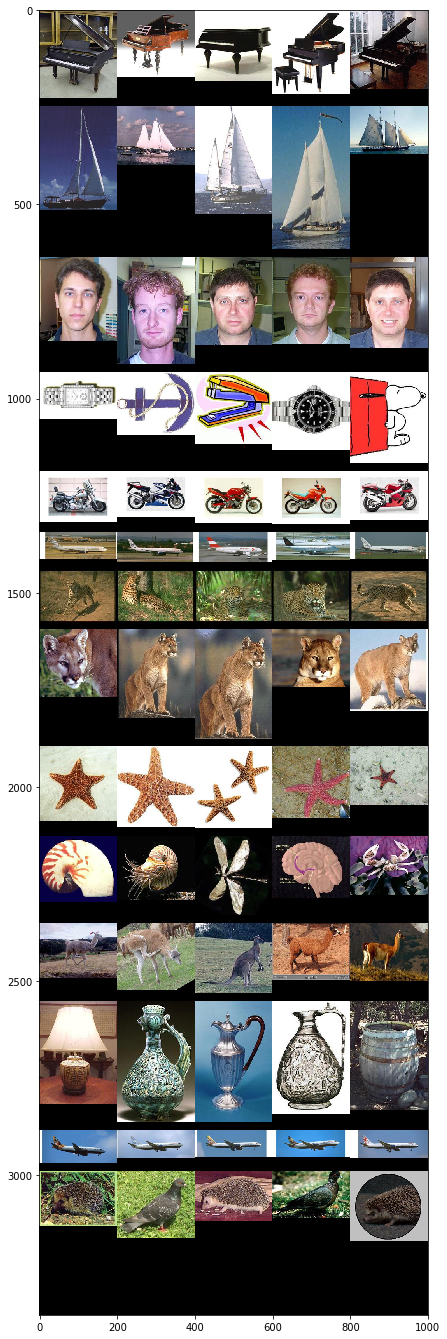

In [10]:
from PIL import Image

img_width = 200

grid_image = Image.new('RGB', (5 * img_width, len(closest) * 240), (0, 0, 0, 255))

max_height = 0
for cluster_row in closest:
    max_height_temp = 0
    xpos = 0
    for col_num in cluster_row:
        img = Image.open(images[col_num])
        img_ar = img.width / img.height
        img = img.resize((img_width, int(img_width / img_ar)), Image.ANTIALIAS)
        max_height_temp = max(max_height_temp, img.height)
        grid_image.paste(img, (xpos, max_height))
        xpos = xpos + img.width
    max_height = max_height + max_height_temp + 20 # adding 20 pixel margin

plt.figure(figsize = (32,24))
plt.imshow(grid_image)

## Dimensionality Reduction

Now that we have a good sense of our clusters, we can try reducing the dimensionality of our data in order to visualize it in two dimensions. We'll use UMAP, a newer and objectively better alternative to t-SNE. Be sure to run 
```bash
$ pip install umap-learn
```

First we will import umap and create our embedding.

In [11]:
import umap

embedding = umap.UMAP().fit_transform(scaled)

Next we need to scale our data between 0 and 1 in order to plot it. scikit-learn has yet another great and easy to use preprocessor for this called the MinMaxScaler. Then we use PIL to draw our images in their new two dimensional space.

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(embedding)
embedding_scaled = scaler.transform(embedding)

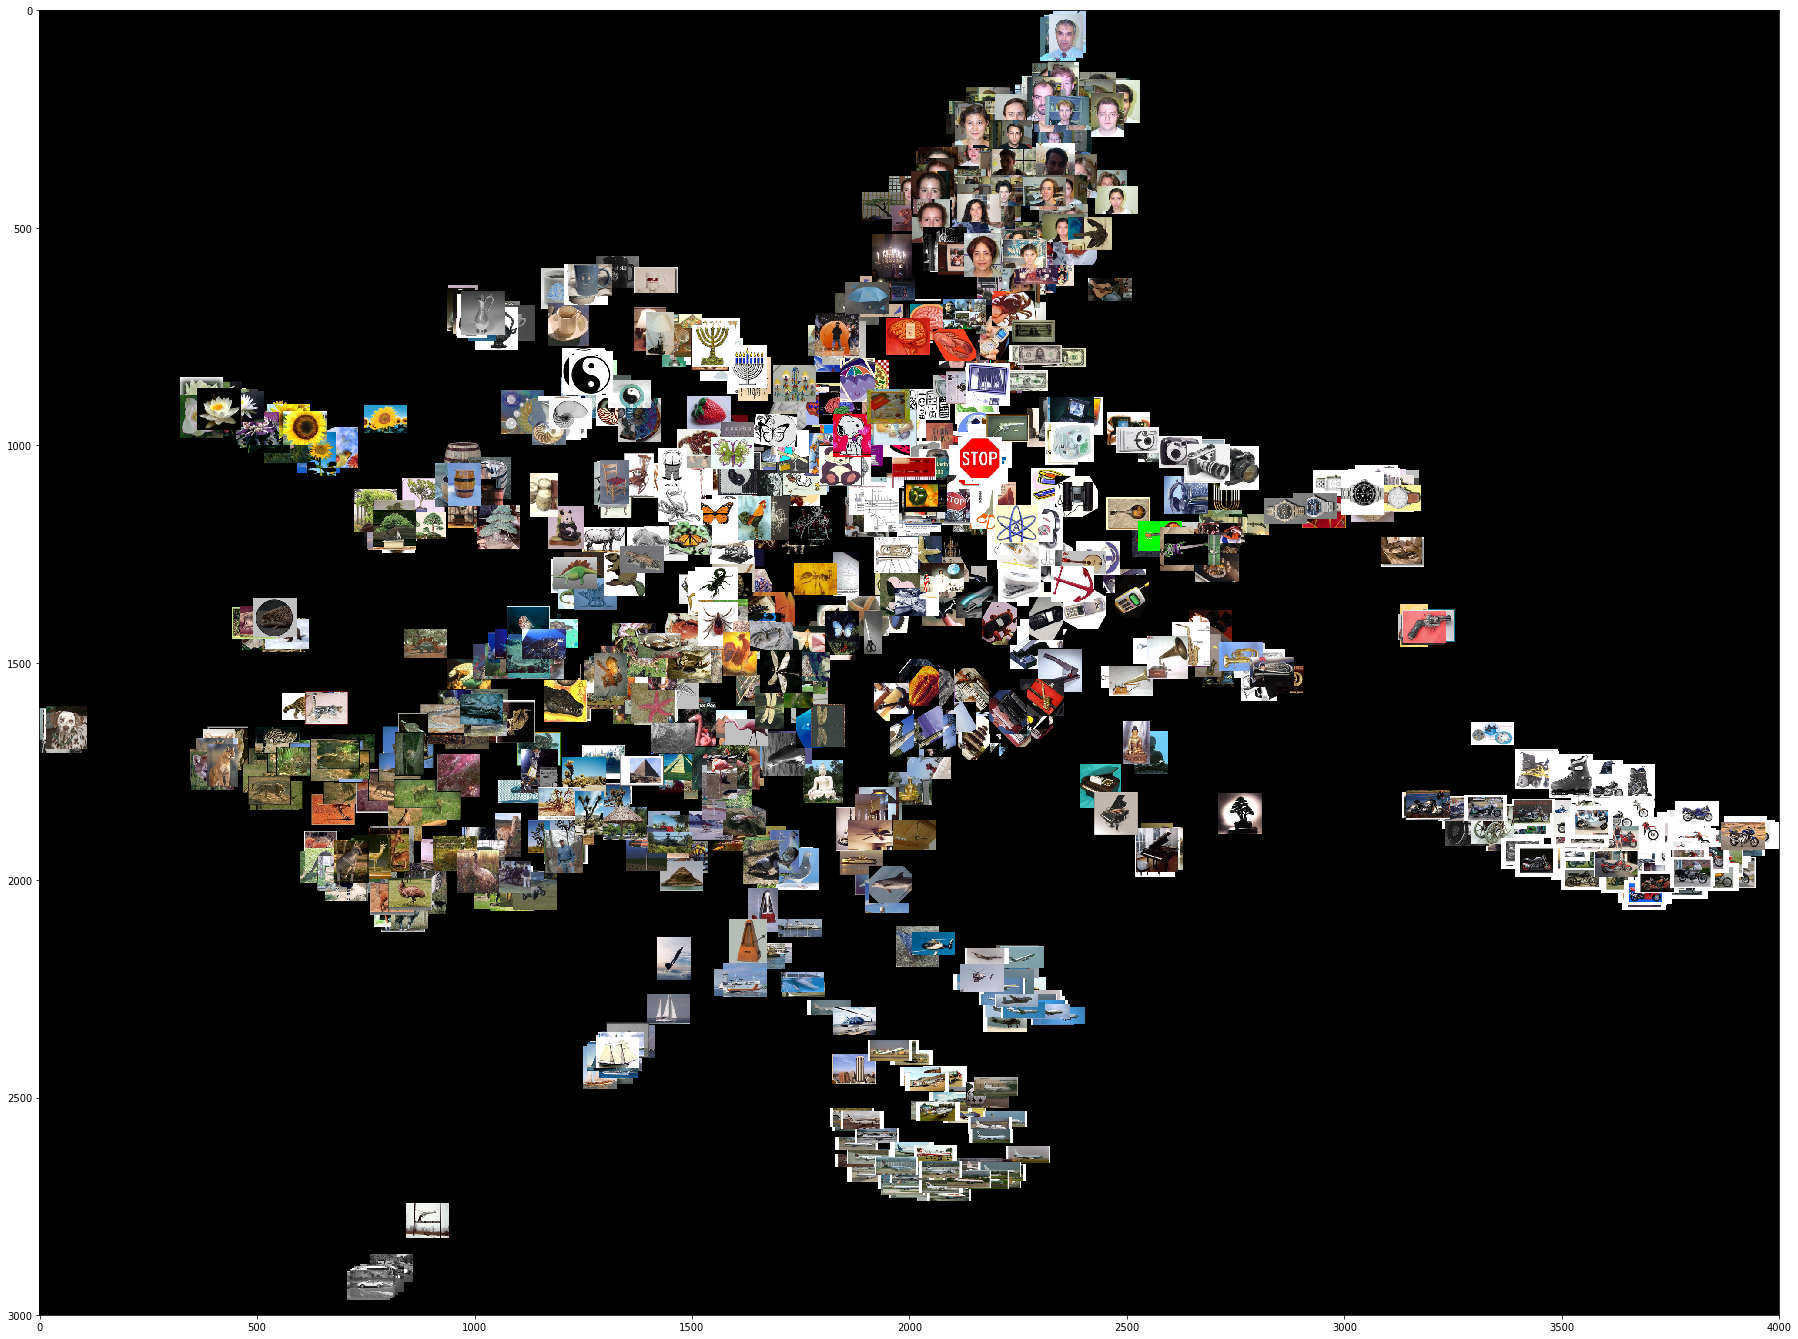

In [13]:
width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height), (0, 0, 0, 255))
for img, pos in zip(images, embedding_scaled):
    x = pos[0]
    y = pos[1]
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

plt.figure(figsize = (32,24))
plt.imshow(full_image)

## Rasterfairy

Finally, we can convert our point cloud into a 2d grid using [Rasterfairy](https://github.com/Quasimondo/RasterFairy). Be sure that `nx` and `ny` are factors of the number of images you are analyzing since they are the horizontal and vertical components of your grid - their product must equal 1000 in our case. Try playing with the drawing code in the cell below to center the images better.

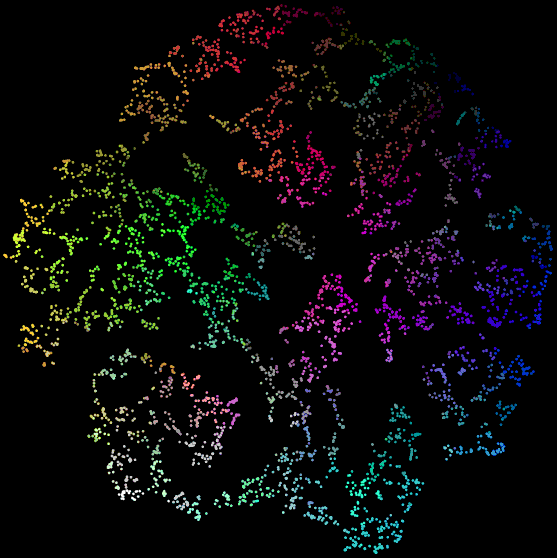
photo from [Rasterfairy](https://github.com/Quasimondo/RasterFairy)

In [14]:
import rasterfairy

nx = 40
ny = 25

grid_assignment = rasterfairy.transformPointCloud2D(embedding, target=(nx, ny))

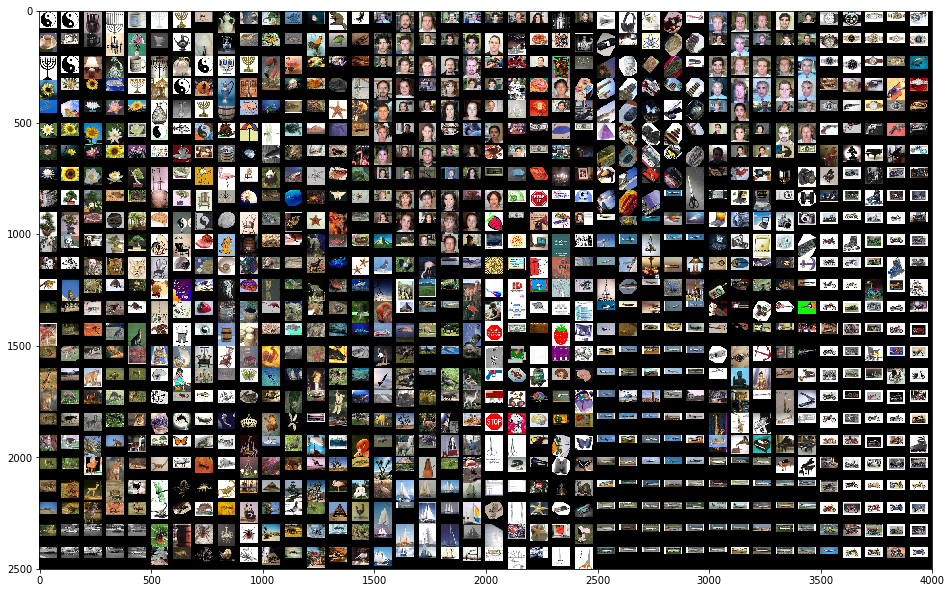

In [15]:
tile_width = 100
tile_height = 100

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = tile_width / tile_height

grid_image = Image.new('RGB', (full_width, full_height), (0, 0, 0, 255))

for img, grid_pos in zip(images, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = tile.width / tile.height
    tile = tile.resize((int(0.8 * tile_width), int(0.8 * tile_height / tile_ar)), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

plt.figure(figsize = (16,12))
plt.imshow(grid_image)

In [28]:
lookup = []

for image, grid_pos, cluster_pos in zip(images, grid_assignment[0], embedding_scaled):
    lookup.append({
        "filename": image.replace('./', ''),
        "grid_pos": grid_pos.tolist(),
        "cluster_pos": cluster_pos.tolist()
    })

In [31]:
import json

with open('image_umap_position.json', 'w') as outfile:
    json.dump(lookup, outfile)

In [32]:
! open .